left_padding shape: torch.Size([1, 1, 15]), x_shape= torch.Size([1, 1, 130]), right_padding shape: torch.Size([1, 1, 15])
x_fully_padded shape: torch.Size([1, 1, 160])
Crop amount: 4, Identity shape: torch.Size([1, 64, 160]), Out shape: torch.Size([1, 64, 152])
Crop amount: 4, Identity shape: torch.Size([1, 64, 152]), Out shape: torch.Size([1, 64, 144])
Crop amount: 4, Identity shape: torch.Size([1, 64, 144]), Out shape: torch.Size([1, 64, 136])
Crop amount: 4, Identity shape: torch.Size([1, 64, 136]), Out shape: torch.Size([1, 64, 128])
Input shape: torch.Size([1, 1, 130]), Output shape: torch.Size([1, 128])


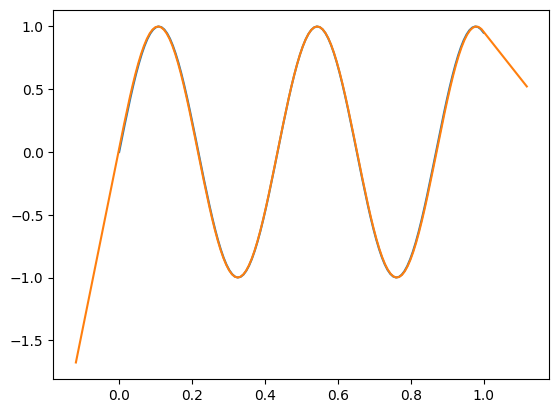

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

class ResidualBlock1D(nn.Module):
    """A residual block that uses unpadded convolutions and crops the identity."""
    def __init__(self, channels, kernel_size=3, activation=nn.ReLU):
        super(ResidualBlock1D, self).__init__()
        self.activation = activation()
        self.conv1 = nn.Conv1d(channels, channels, kernel_size, padding=0, bias=False)
        self.bn1 = nn.InstanceNorm1d(channels, affine=True)
        self.conv2 = nn.Conv1d(channels, channels, kernel_size, padding=0, bias=False)
        self.bn2 = nn.InstanceNorm1d(channels, affine=True)

    def forward(self, x):
        identity = x
        out = self.activation(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        
        crop_amount = (identity.shape[2] - out.shape[2]) // 2
        print(f"Crop amount: {crop_amount}, Identity shape: {identity.shape}, Out shape: {out.shape}")  # Debugging line
        if crop_amount > 0:
            identity = identity[:, :, crop_amount:-crop_amount]
        
        out += identity
        return self.activation(out)

class CNN_RES(nn.Module):
    def __init__(self, hidden_channels, num_blocks=2, kernel_size=3, activation=nn.ReLU):
        super(CNN_RES, self).__init__()
        self.activation = activation()
        self.hidden_channels = hidden_channels
        self.num_blocks = num_blocks
        self.kernel_size = kernel_size
        
        self.conv_in = nn.Conv1d(1, hidden_channels, kernel_size=1, bias=False)
        self.bn_in = nn.InstanceNorm1d(hidden_channels, affine=True)
        
        layers = [ResidualBlock1D(hidden_channels, kernel_size, activation=activation) for _ in range(num_blocks)]
        self.res_blocks = nn.Sequential(*layers)
        
        self.conv_out = nn.Conv1d(hidden_channels, 1, kernel_size=1)
    
    def forward(self, x):
        """
        Expects a pre-padded input with one ghost cell on each side (e.g., 130 length).
        Applies a custom linear extrapolation padding for inner layers.
        """
        if x.dim() == 2:
            x = x.unsqueeze(1) # Add channel dim: (B, 1, L)

        # --- CORRECTED LINEAR EXTRAPOLATION PADDING ---

        # 1. Calculate total padding needed per side for the entire network.
        total_pad_per_side = self.num_blocks * (self.kernel_size - 1) - 1  # -1 because input already has 1 ghost cell
        
        # 2. Separate the ghost cells and the internal domain.
        ghost_cell_left = x[:, :, :1]
        ghost_cell_right = x[:, :, -1:]

        # 3. Calculate the gradient at each boundary.
        # grad_left = (-11 * ghost_cell_left + 18 * x[:, :, 1:2] - 9 * x[:, :, 2:3] + 2 * x[:, :, 3:4]) / 6
        # grad_right = (11 * ghost_cell_right - 18 * x[:, :, -2:-1] + 9 * x[:, :, -3:-2] - 2 * x[:, :, -4:-3]) / 6
        grad_left = (x[:, :, 1:2] - ghost_cell_left)
        grad_right = (ghost_cell_right - x[:, :, -2:-1])
        
        # 4. Generate the extrapolated padding tensors.
        left_ramp = torch.arange(total_pad_per_side, 0, -1, device=x.device, dtype=x.dtype).view(1, 1, -1)
        left_padding = ghost_cell_left - left_ramp * grad_left

        right_ramp = torch.arange(1, total_pad_per_side + 1, device=x.device, dtype=x.dtype).view(1, 1, -1)
        right_padding = ghost_cell_right + right_ramp * grad_right

        print(f"left_padding shape: {left_padding.shape}, x_shape= {x.shape}, right_padding shape: {right_padding.shape}")  # Debugging line
        
        x_fully_padded = torch.cat([left_padding, x, right_padding], dim=2)

        pad_fraction = (total_pad_per_side+4) / x_fully_padded.shape[2]

        plt.plot(np.linspace(-pad_fraction, 1+pad_fraction, x_fully_padded.shape[2]), x_fully_padded[0,0,:].cpu().numpy())
        print(f"x_fully_padded shape: {x_fully_padded.shape}")  # Debugging line
        
        
        # The rest of the forward pass is the same
        out = self.activation(self.bn_in(self.conv_in(x_fully_padded)))
        out = self.res_blocks(out)
        out = self.conv_out(out)
        
        return out.squeeze(1)
    

HIDDEN_SIZE = 64
NUM_RES_BLOCKS = 4
KERNEL_SIZE = 5

model = CNN_RES(
    hidden_channels=HIDDEN_SIZE,
    num_blocks=NUM_RES_BLOCKS,
    kernel_size=KERNEL_SIZE
)

x_coords = np.linspace(0, 1, 130)
input_np = np.sin(x_coords*4.6 * np.pi)  # Example input with ghost cells
plt.plot(x_coords, input_np)
input_tensor = torch.tensor(input_np, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # (B, C, L) with ghost cells
output_tensor = model(input_tensor)
prediction_np = output_tensor.detach().numpy().squeeze()
print(f"Input shape: {input_tensor.shape}, Output shape: {output_tensor.shape}")

x_fully_padded shape: torch.Size([1, 1, 160])
Crop amount: 4, Identity shape: torch.Size([1, 64, 160]), Out shape: torch.Size([1, 64, 152])
Crop amount: 4, Identity shape: torch.Size([1, 64, 152]), Out shape: torch.Size([1, 64, 144])
Crop amount: 4, Identity shape: torch.Size([1, 64, 144]), Out shape: torch.Size([1, 64, 136])
Crop amount: 4, Identity shape: torch.Size([1, 64, 136]), Out shape: torch.Size([1, 64, 128])
Input shape: torch.Size([1, 1, 130]), Output shape: torch.Size([1, 128])


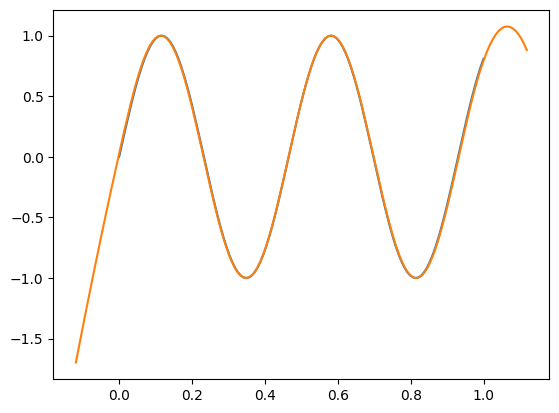

In [3]:
class CNN_RES(nn.Module):
    def __init__(self, hidden_channels, num_blocks=2, kernel_size=3, activation=nn.ReLU):
        super(CNN_RES, self).__init__()
        self.activation = activation()
        self.hidden_channels = hidden_channels
        self.num_blocks = num_blocks
        self.kernel_size = kernel_size
        
        self.conv_in = nn.Conv1d(1, hidden_channels, kernel_size=1, bias=False)
        self.bn_in = nn.InstanceNorm1d(hidden_channels, affine=True)
        
        layers = [ResidualBlock1D(hidden_channels, kernel_size, activation=activation) for _ in range(num_blocks)]
        self.res_blocks = nn.Sequential(*layers)
        
        self.conv_out = nn.Conv1d(hidden_channels, 1, kernel_size=1)
    
    def forward(self, x):
        """
        Expects a pre-padded input with one ghost cell on each side (e.g., 130 length).
        Applies a custom QUADRATIC (2nd-order) extrapolation padding for inner layers.
        """
        if x.dim() == 2:
            x = x.unsqueeze(1) # Add channel dim: (B, 1, L)

        # --- QUADRATIC EXTRAPOLATION PADDING ---

        # 1. Calculate total padding needed for all convs to maintain the final size.
        total_pad_per_side = self.num_blocks * (self.kernel_size - 1) - 1 # -1 because input already has 1 ghost cell
        
        # 2. Extract the points needed to define the polynomial at each boundary.
        #    We need 3 points for a quadratic fit.
        # Left side points: ghost cell, first two internal points
        p_left_0 = x[:, :, 0]  # bc_left at x=-1
        p_left_1 = x[:, :, 1]  # u_internal[0] at x=0
        p_left_2 = x[:, :, 2]  # u_internal[1] at x=1

        # Right side points: last two internal points, ghost cell
        p_right_0 = x[:, :, -3] # u_internal[-2]
        p_right_1 = x[:, :, -2] # u_internal[-1]
        p_right_2 = x[:, :, -1] # bc_right
        
        # 3. Calculate first and second derivatives at the boundaries using finite differences.
        #    These derivatives define the shape of our extrapolation polynomial. (Assuming dx=1)
        grad1_left = (p_left_1 - p_left_0) # 1st order forward diff at boundary
        grad2_left = (p_left_2 - 2 * p_left_1 + p_left_0) # 2nd order central diff for curvature

        grad1_right = (p_right_2 - p_right_1) # 1st order backward diff at boundary
        grad2_right = (p_right_2 - 2 * p_right_1 + p_right_0) # 2nd order central diff for curvature
        
        # 4. Generate the extrapolated padding tensors using a Taylor expansion.
        #    u(x) approx u(x_b) + (x-x_b)*g1 + 0.5*(x-x_b)^2*g2
        
        # Create coordinates for the padding cells, relative to the ghost cell.
        # Left side coordinates are -1, -2, ..., -total_pad
        left_dist = torch.arange(1, total_pad_per_side + 1, device=x.device, dtype=x.dtype).view(1, 1, -1)
        # We extrapolate backwards from p_left_0 (the ghost cell)
        left_padding = p_left_0.unsqueeze(2) - left_dist * grad1_left.unsqueeze(2) + 0.5 * (left_dist**2) * grad2_left.unsqueeze(2)
        # We need to reverse the order to concatenate correctly
        left_padding = torch.flip(left_padding, [2])

        # Right side coordinates are 1, 2, ..., total_pad
        right_dist = torch.arange(1, total_pad_per_side + 1, device=x.device, dtype=x.dtype).view(1, 1, -1)
        # We extrapolate forwards from p_right_2 (the ghost cell)
        right_padding = p_right_2.unsqueeze(2) + right_dist * grad1_right.unsqueeze(2) + 0.5 * (right_dist**2) * grad2_right.unsqueeze(2)

        # 5. Concatenate everything to form the fully padded tensor.
        x_fully_padded = torch.cat([left_padding, x, right_padding], dim=2)

        pad_fraction = (total_pad_per_side+4) / x_fully_padded.shape[2]

        plt.plot(np.linspace(-pad_fraction, 1+pad_fraction, x_fully_padded.shape[2]), x_fully_padded[0,0,:].cpu().numpy())
        print(f"x_fully_padded shape: {x_fully_padded.shape}")  # Debugging line
        
        # The rest of the forward pass is the same
        out = self.activation(self.bn_in(self.conv_in(x_fully_padded)))
        out = self.res_blocks(out)
        out = self.conv_out(out)
        
        return out.squeeze(1)

HIDDEN_SIZE = 64
NUM_RES_BLOCKS = 4
KERNEL_SIZE = 5

model = CNN_RES(
    hidden_channels=HIDDEN_SIZE,
    num_blocks=NUM_RES_BLOCKS,
    kernel_size=KERNEL_SIZE
)

x_coords = np.linspace(0, 1, 130)
input_np = np.sin(x_coords * 4.3 * np.pi)  # Example input with ghost cells
plt.plot(x_coords, input_np)
input_tensor = torch.tensor(input_np, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # (B, C, L) with ghost cells
output_tensor = model(input_tensor)
prediction_np = output_tensor.detach().numpy().squeeze()
print(f"Input shape: {input_tensor.shape}, Output shape: {output_tensor.shape}")

/home/dan/venvs/torch/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
/tmp/ipykernel_154460/3874914525.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` fo

Input shape: torch.Size([1, 1, 130]), Prediction shape: torch.Size([1, 128])


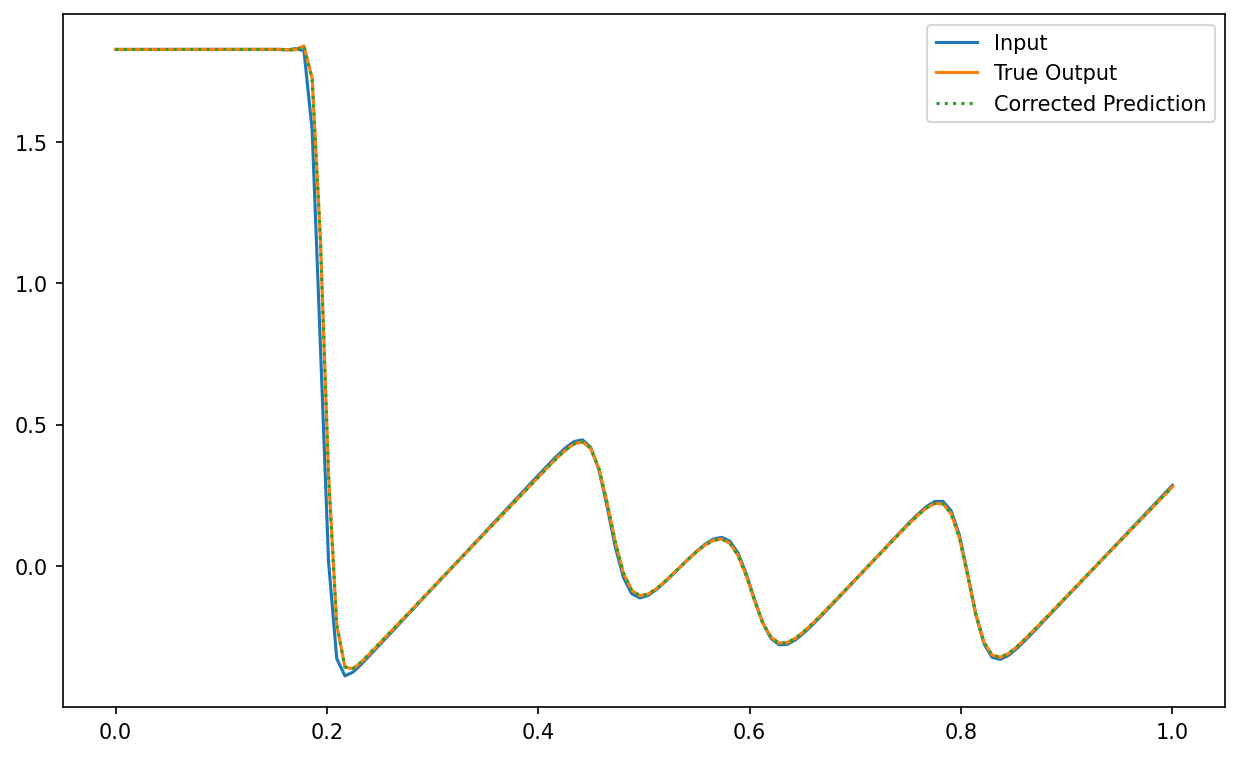

In [4]:
import os

GHOST_CELLS=2
from torch.nn.utils import weight_norm


class LinearExtrapolationPadding1D(nn.Module):
    """Applies 'same' padding using linear extrapolation."""
    def __init__(self, kernel_size: int, dilation: int = 1):
        super().__init__()
        # Formula for 'same' padding
        self.pad_total = dilation * (kernel_size - 1)
        self.pad_beg = self.pad_total // 2
        self.pad_end = self.pad_total - self.pad_beg

    def forward(self, x):
        # Don't pad if not necessary
        if self.pad_total == 0:
            return x

        # 1. Separate the first and last actual data points.
        ghost_cell_left = x[:, :, :1]
        ghost_cell_right = x[:, :, -1:]

        # 2. Calculate the gradient at each boundary.
        grad_left = x[:, :, 1:2] - ghost_cell_left
        grad_right = ghost_cell_right - x[:, :, -2:-1]

        # grad_left = ( -11 * ghost_cell_left + 18 * x[:, :, 1:2] - 9 * x[:, :, 2:3] + 2 * x[:, :, 3:4]) / 6
        # grad_right = (11 * ghost_cell_right - 18 * x[:, :, -2:-1] + 9 * x[:, :, -3:-2] - 2 * x[:, :, -4:-3]) / 6

        # 3. Generate the extrapolated padding tensors.
        left_ramp = torch.arange(self.pad_beg, 0, -1, device=x.device, dtype=x.dtype).view(1, 1, -1)
        left_padding = ghost_cell_left - left_ramp * grad_left

        right_ramp = torch.arange(1, self.pad_end + 1, device=x.device, dtype=x.dtype).view(1, 1, -1)
        right_padding = ghost_cell_right + right_ramp * grad_right
        
        return torch.cat([left_padding, x, right_padding], dim=2)

class ResidualBlock1D(nn.Module):
    """A residual block that uses custom 'same' padding with linear extrapolation and weight normalization."""
    def __init__(self, channels, kernel_size=3, activation=nn.ReLU):
        super(ResidualBlock1D, self).__init__()
        self.activation = activation()
        # Apply weight normalization and remove bias and instance norm
        self.conv1 = weight_norm(nn.Conv1d(channels, channels, kernel_size, padding='valid', bias=True))
        self.ghost_padding1 = LinearExtrapolationPadding1D(kernel_size)
        self.conv2 = weight_norm(nn.Conv1d(channels, channels, kernel_size, padding='valid', bias=True))
        self.ghost_padding2 = LinearExtrapolationPadding1D(kernel_size)

    def forward(self, x):
        identity = x
        
        out = self.ghost_padding1(x)
        out = self.conv1(out)
        out = self.activation(out)
        
        out = self.ghost_padding2(out)
        out = self.conv2(out)

        return self.activation(out) + identity
class CNN_RES(nn.Module):
    def __init__(self, hidden_channels, num_blocks=2, kernel_size=3, activation=nn.ReLU, ghost_cells=2):
        super(CNN_RES, self).__init__()
        self.activation = activation()
        self.hidden_channels = hidden_channels
        self.num_blocks = num_blocks
        self.kernel_size = kernel_size
        assert ghost_cells % 2 == 0, "ghost_cells must be even"
        self.ghost_cells = ghost_cells
        
        self.ghost_padding = LinearExtrapolationPadding1D(self.ghost_cells + self.kernel_size)

        # Apply weight normalization to the input convolution
        self.conv_in = weight_norm(nn.Conv1d(1, hidden_channels, kernel_size=1, bias=True))
        
        layers = [ResidualBlock1D(hidden_channels, kernel_size, activation=activation) for _ in range(num_blocks)]
        self.res_blocks = nn.Sequential(*layers)
        
        self.conv_out = nn.Conv1d(hidden_channels, 1, kernel_size=1)
    
    def forward(self, x):
        """
        Expects a pre-padded input with ghost_cells//2 number ghost cells on each side.
        Applies a custom linear extrapolation padding for inner layers.
        """
        if x.dim() == 2:
            x = x.unsqueeze(1) # Add channel dim: (B, 1, L)

        if not self.ghost_cells == 0:
            x_padded = self.ghost_padding(x)
            
        else:
            x_padded = x

        total_pad_each_side = self.ghost_padding.pad_beg + self.ghost_cells // 2

        out = self.activation(self.conv_in(x_padded)) # no extra padding here
        out = self.res_blocks(out)
        out = self.conv_out(out) # no extra padding here

        if not self.ghost_cells == 0:
            out = out[:, :, total_pad_each_side:-total_pad_each_side] # remove ghost cells
        
        return out.squeeze(1)


HIDDEN_SIZE = 64
NUM_RES_BLOCKS = 4
KERNEL_SIZE = 5

model = CNN_RES(
    hidden_channels=HIDDEN_SIZE,
    num_blocks=NUM_RES_BLOCKS,
    kernel_size=KERNEL_SIZE,
    ghost_cells=GHOST_CELLS,
    activation=nn.ReLU
)

project_root = "/home/dan/neural-adapter"
models_dir = os.path.join(project_root, "neural_surrogate", "models")
model_name = "CNN_RES_UNROLL_5.pth"
model_path = os.path.join(models_dir, model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

DATA_DIR = os.path.join(project_root, "tutorials/partitioned-burgers-1d/solver-scipy-fvolumes/data-training/")
npz_files = [f for f in os.listdir(DATA_DIR) if f.endswith('.npz')]
if not npz_files:
    print("No .npz files found for evaluation.")
    
timestep = 50
# file_num = 0
file_num = np.random.randint(0, len(npz_files) - 1)
data_path = os.path.join(DATA_DIR, npz_files[file_num])
raw_data = np.load(data_path)['Solver-Mesh-1D-Internal'][:, :130]
input_np = raw_data[timestep]
output_np = raw_data[timestep + 1]

x_coords = np.linspace(0, 1, 130)

# input_np = 1*np.sin(x_coords * 4.3 * np.pi)  # Example input with ghost cells

plt.figure(figsize=(10,6), dpi=150)
plt.plot(x_coords, input_np, label='Input')
plt.plot(x_coords, output_np, label='True Output')

input_tensor = torch.tensor(input_np, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # (B, C, L) with ghost cells
output_tensor = model(input_tensor)
prediction_np = output_tensor.detach().numpy().squeeze()

print(f"Input shape: {input_tensor.shape}, Prediction shape: {output_tensor.shape}")

if not GHOST_CELLS == 0:
    # plt.plot(x_coords[GHOST_CELLS//2:-GHOST_CELLS//2], prediction_np, label='Predicted Output', linestyle='--')

    prediction_corrected = np.zeros_like(input_np)
    prediction_corrected[GHOST_CELLS//2:-GHOST_CELLS//2] = prediction_np
    prediction_corrected[:GHOST_CELLS//2] = output_np[:GHOST_CELLS//2]  # Use true values for ghost cells
    prediction_corrected[-GHOST_CELLS//2:] = output_np[-GHOST_CELLS//2:]  # Use true values for ghost cells
    plt.plot(x_coords, prediction_corrected, label='Corrected Prediction', linestyle=':')

else:
    plt.plot(x_coords, prediction_np, label='Predicted Output', linestyle='--')

plt.legend()
plt.show()